## Automated Rice Plant Disease Classification Using Image Processing and Machine Learning


#### Course: CSC 8260 (Course Project)

## Objective


The aim of this project is to implement a rice leaf disease classification system using transfer learning with two pretrained convolutional neural network architectures: ResNet50 and VGG16. The dataset consists of labeled images categorized into three classes: Bacterial Leaf Blight, Brown Spot, and Blast, with 1300 images per class. 

## Steps:
1. **Data preprocessing and augmentation**
2. **Dataset visualization and distribution analysis**
4. **Model Setup: Transfer Learning using ResNet50 and VGG16**
    - Load pretrained weights from ImageNet.
    - Freeze the convolutional base to retain learned features.
    - Add custom fully connected layers for classification (Dropout + Dense)
5. **Model Training**
6. **Model Evaluation**
6. **Analysis and Discussion**

In [1]:
# install required libraries

!pip install torch numpy
!pip install matplotlib
!pip install seaborn scikit-learn
!pip install torchvision
!pip install pillow numpy
!pip install torchsummary tqdm


[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import required libraries

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## Step 1: Load and Transform Dataset

In [3]:

# Define image transformations to match input requirements for the architectures
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = "Rice_Dataset"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Step 2: Dataset visualization and distribution analysis

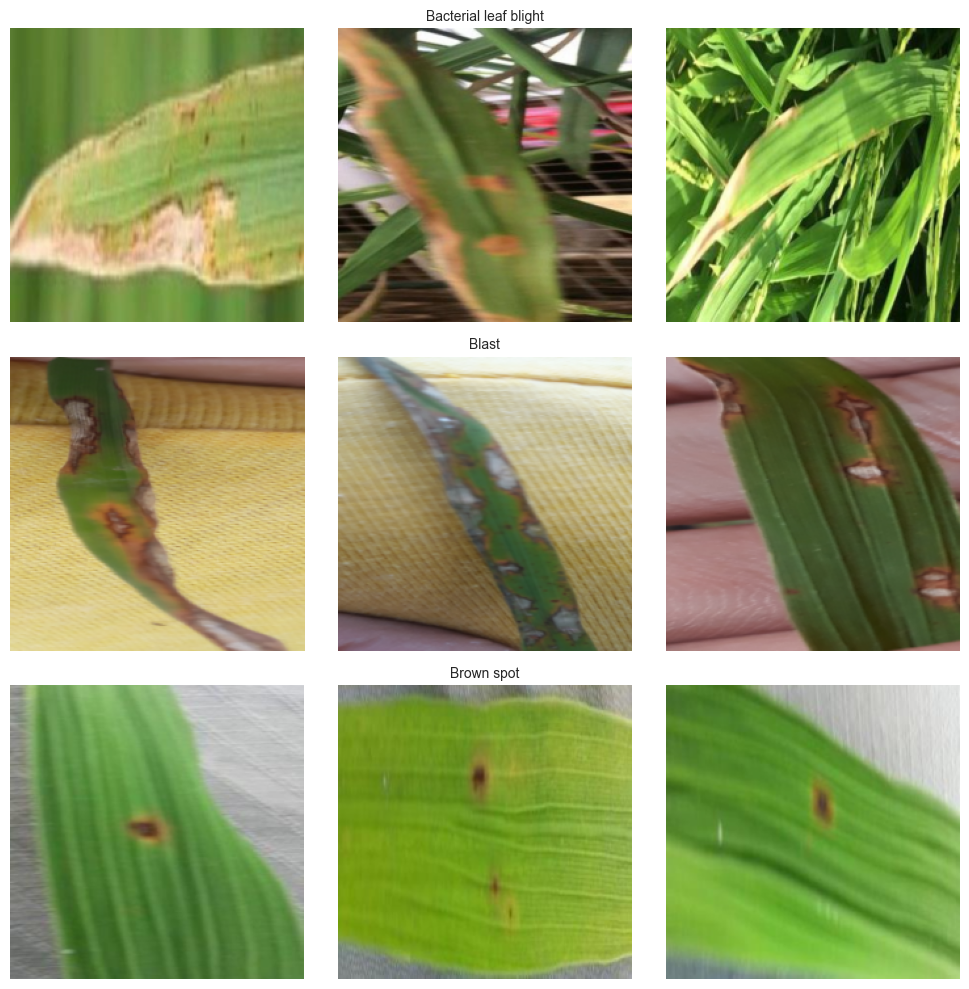

In [4]:
# Denormalize images for visualization
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_tensor = img_tensor.numpy().transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    img_tensor = std * img_tensor + mean  # Denormalize
    img_tensor = np.clip(img_tensor, 0, 1) 
    return img_tensor

# Display three samples from each rice disease class
def display_samples(dataset, loader, num_samples=3):
    fig, axes = plt.subplots(len(dataset.classes), num_samples, figsize=(10, 10))

    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Loop through and display samples
    for i, category in enumerate(dataset.classes):
        indices = (labels == i).nonzero(as_tuple=True)[0][:num_samples] 
        for j, idx in enumerate(indices):
            img = denormalize(images[idx])  # Denormalize
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 1:
                axes[i, j].set_title(category, fontsize=10) 

    plt.tight_layout()
    plt.show()

# Display the samples from the train dataset
display_samples(train_dataset, train_loader, num_samples=3)

### Display Data Distribution

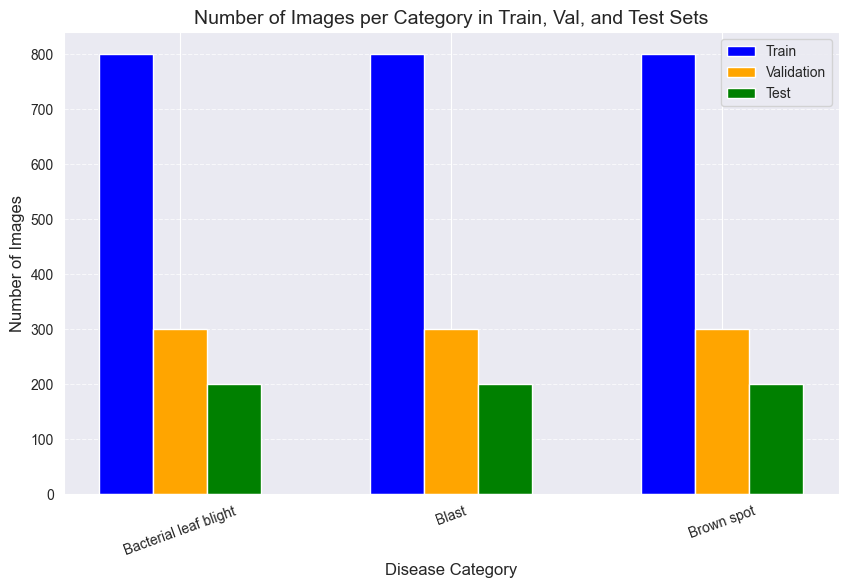

In [5]:

# Get category names
categories = os.listdir(os.path.join(data_dir, "train")) 

# Count images per category in train, val, and test
image_counts = {category: {"train": 0, "val": 0, "test": 0} for category in categories}

for split in ["train", "val", "test"]:
    for category in categories:
        category_path = os.path.join(data_dir, split, category)
        image_counts[category][split] = len(os.listdir(category_path))

# Convert counts to lists for visualization
category_names = list(image_counts.keys())
train_counts = [image_counts[cat]["train"] for cat in category_names]
val_counts = [image_counts[cat]["val"] for cat in category_names]
test_counts = [image_counts[cat]["test"] for cat in category_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.2
x = range(len(category_names))

plt.bar(x, train_counts, width=bar_width, label="Train", color="blue")
plt.bar([i + bar_width for i in x], val_counts, width=bar_width, label="Validation", color="orange")
plt.bar([i + 2 * bar_width for i in x], test_counts, width=bar_width, label="Test", color="green")

# Formatting
plt.xlabel("Disease Category", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Number of Images per Category in Train, Val, and Test Sets", fontsize=14)
plt.xticks([i + bar_width for i in x], category_names, rotation=20)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


## Step 3: Model Setup

### ResNet50

In [6]:

# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Modify the classifier for 3 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)  # modify the fully connected layer to match 3-class output

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


C:\Users\Kanyin AKinwande\Documents\FIYIN\GSU\Spring 2025\ADV IMAGE PROCESSING\PROJECT\pythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kanyin AKinwande\Documents\FIYIN\GSU\Spring 2025\ADV IMAGE PROCESSING\PROJECT\pythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### VGG16

In [7]:
# Load pretrained VGG16
vgg = models.vgg16(pretrained=True)

# Modify the classifier for 3 classes
vgg.classifier[6] = nn.Linear(4096, 3)  # Last layer to match the number of classes (3)

# Move model to GPU if available
vgg = vgg.to(device)


C:\Users\Kanyin AKinwande\Documents\FIYIN\GSU\Spring 2025\ADV IMAGE PROCESSING\PROJECT\pythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 4: Model Training

Training ResNet...


Epoch 1/10: 100%|██████████| 75/75 [11:27<00:00,  9.17s/it]


Epoch 1, Train Loss: 0.3960, Train Acc: 84.08% | Val Loss: 0.3299, Val Acc: 90.11%


Epoch 2/10: 100%|██████████| 75/75 [09:39<00:00,  7.72s/it]


Epoch 2, Train Loss: 0.1992, Train Acc: 93.33% | Val Loss: 0.1960, Val Acc: 92.44%


Epoch 3/10: 100%|██████████| 75/75 [10:25<00:00,  8.34s/it]


Epoch 3, Train Loss: 0.1351, Train Acc: 96.21% | Val Loss: 0.2682, Val Acc: 95.33%


Epoch 4/10: 100%|██████████| 75/75 [10:12<00:00,  8.16s/it]


Epoch 4, Train Loss: 0.1166, Train Acc: 96.00% | Val Loss: 0.0887, Val Acc: 97.11%


Epoch 5/10: 100%|██████████| 75/75 [09:57<00:00,  7.97s/it]


Epoch 5, Train Loss: 0.0764, Train Acc: 97.54% | Val Loss: 0.1144, Val Acc: 96.00%


Epoch 6/10: 100%|██████████| 75/75 [09:14<00:00,  7.39s/it]


Epoch 6, Train Loss: 0.0740, Train Acc: 97.79% | Val Loss: 0.0241, Val Acc: 99.11%


Epoch 7/10: 100%|██████████| 75/75 [13:40<00:00, 10.93s/it]


Epoch 7, Train Loss: 0.0347, Train Acc: 99.00% | Val Loss: 0.1007, Val Acc: 95.56%


Epoch 8/10: 100%|██████████| 75/75 [09:31<00:00,  7.63s/it]


Epoch 8, Train Loss: 0.0424, Train Acc: 98.38% | Val Loss: 0.0469, Val Acc: 98.44%


Epoch 9/10: 100%|██████████| 75/75 [10:57<00:00,  8.77s/it]


Epoch 9, Train Loss: 0.0276, Train Acc: 99.00% | Val Loss: 0.0036, Val Acc: 99.89%


Epoch 10/10: 100%|██████████| 75/75 [19:39<00:00, 15.72s/it] 


Epoch 10, Train Loss: 0.0456, Train Acc: 98.29% | Val Loss: 0.0678, Val Acc: 97.67%


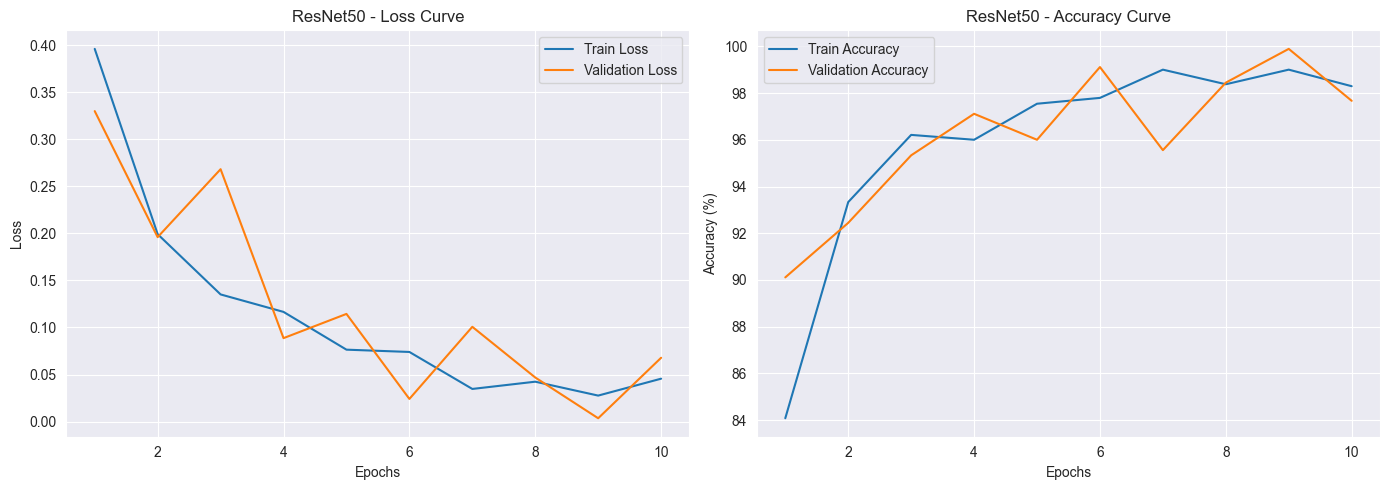

Training VGG16...


Epoch 1/10: 100%|██████████| 75/75 [50:44<00:00, 40.59s/it]  


Epoch 1, Train Loss: 1.0798, Train Acc: 47.75% | Val Loss: 0.7117, Val Acc: 70.89%


Epoch 2/10: 100%|██████████| 75/75 [42:22<00:00, 33.90s/it]


Epoch 2, Train Loss: 0.6805, Train Acc: 69.25% | Val Loss: 0.4865, Val Acc: 79.11%


Epoch 3/10: 100%|██████████| 75/75 [37:20<00:00, 29.87s/it] 


Epoch 3, Train Loss: 0.5185, Train Acc: 78.50% | Val Loss: 0.3942, Val Acc: 82.11%


Epoch 4/10: 100%|██████████| 75/75 [31:42<00:00, 25.37s/it]


Epoch 4, Train Loss: 0.6004, Train Acc: 75.25% | Val Loss: 0.4800, Val Acc: 81.33%


Epoch 5/10: 100%|██████████| 75/75 [27:27<00:00, 21.97s/it]


Epoch 5, Train Loss: 0.4602, Train Acc: 81.92% | Val Loss: 0.4085, Val Acc: 80.67%


Epoch 6/10: 100%|██████████| 75/75 [17:25<00:00, 13.94s/it]


Epoch 6, Train Loss: 0.4806, Train Acc: 80.79% | Val Loss: 0.4239, Val Acc: 81.22%
Early stopping triggered!


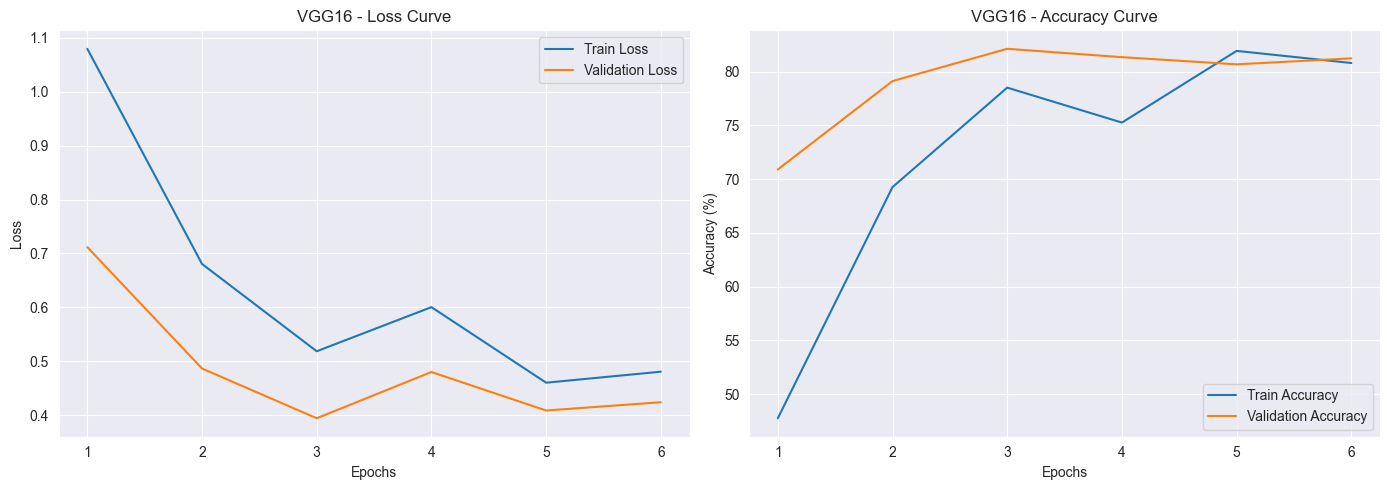

In [8]:

# Define Loss Function and Optimizer (Adam optimizer)
criterion = nn.CrossEntropyLoss() 
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=0.001)
optimizer_vgg = torch.optim.Adam(vgg.parameters(), lr=0.001)

# Validation function to evaluate the model on the validation set
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient tracking for faster inference
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)   # Get predicted class
            correct += (predicted == labels).sum().item()    # count correct predictions
            total += labels.size(0)

    # Calculate average loss and accuracy over validation set
    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Early stopping class to monitor the validation loss or accuracy
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        """
        Args:
        - patience: Number of epochs to wait for improvement before stopping
        - delta: Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None  # Track best validation loss
        self.best_weights = None  # Store the best weights
        self.early_stop = False  # Flag to indicate whether to stop early

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0  # Reset the counter when there's an improvement
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            print("Early stopping triggered!")
            model.load_state_dict(self.best_weights)  # Restore the best model weights


# Define the training loop with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, patience=3, device="cuda"):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    # a dictionary to keep track of loss and accuracy for both training and validation sets at each epoch.
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # train the model
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)             # forward pass
            loss = criterion(outputs, labels)   # compute loss
            loss.backward()                     # back propagation
            optimizer.step()                    # update model weights

            running_loss += loss.item()                    # accumulate training loss
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()  # count correct predictions
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)       # average training loss
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # print progress summary
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            break

    return model, history


# plot learning curves
def plot_learning_curves(history, model_name="Model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



print("Training ResNet...")
resnet, resnet_history = train_model_with_early_stopping(resnet, train_loader, val_loader, optimizer_resnet, criterion, num_epochs=10, patience=3, device=device)
plot_learning_curves(resnet_history, model_name="ResNet50")

print("Training VGG16...")
vgg, vgg_history = train_model_with_early_stopping(vgg, train_loader, val_loader, optimizer_vgg, criterion, num_epochs=10, patience=3, device=device)
plot_learning_curves(vgg_history, model_name="VGG16")





## Step 5: Model Evaluation

Evaluating ResNet on Test Set...
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.96      1.00      0.98       200
           Brown Spot       0.99      0.96      0.98       200
            Leaf Smut       1.00      0.99      1.00       200

             accuracy                           0.98       600
            macro avg       0.99      0.98      0.98       600
         weighted avg       0.99      0.98      0.98       600



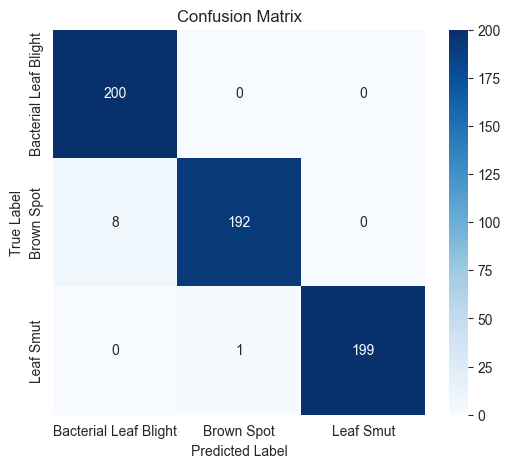

Evaluating VGG16 on Test Set...
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.67      0.97      0.79       200
           Brown Spot       0.78      0.57      0.66       200
            Leaf Smut       1.00      0.81      0.90       200

             accuracy                           0.79       600
            macro avg       0.82      0.79      0.78       600
         weighted avg       0.82      0.79      0.78       600



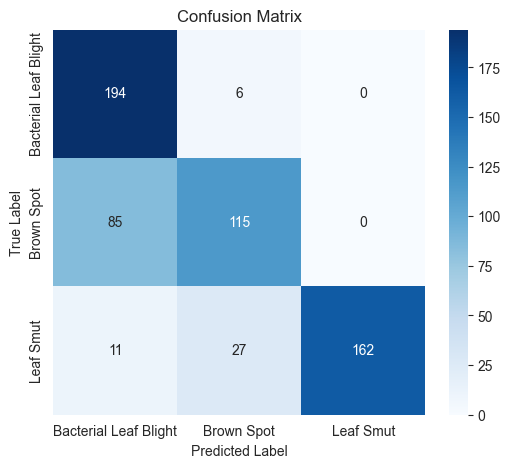

In [9]:

# print classification report for both models
def detailed_evaluation(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    return y_true, y_pred
    

# plot confusion matrix for both models
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ['Bacterial Leaf Blight', 'Brown Spot', 'Leaf Smut']  # Update to match your actual folder names

# evaluate resnet
print("Evaluating ResNet on Test Set...")
y_true_resnet, y_pred_resnet = detailed_evaluation(resnet, test_loader, device, class_names)

plot_confusion_matrix(y_true_resnet, y_pred_resnet, class_names)


# evaluate vgg
print("Evaluating VGG16 on Test Set...")
y_true_vgg, y_pred_vgg = detailed_evaluation(vgg, test_loader, device, class_names)

plot_confusion_matrix(y_true_vgg, y_pred_vgg, class_names)


In [10]:
# compare model accuarcies
from sklearn.metrics import accuracy_score

acc_resnet = accuracy_score(y_true_resnet, y_pred_resnet)
acc_vgg = accuracy_score(y_true_vgg, y_pred_vgg)

print(f"ResNet Accuracy: {acc_resnet * 100:.2f}%")
print(f"VGG16 Accuracy: {acc_vgg * 100:.2f}%")



ResNet Accuracy: 98.50%
VGG16 Accuracy: 78.50%


Class-wise Accuracy:

Bacterial Leaf Blight: 100.00%
Brown Spot: 96.00%
Leaf Smut: 99.50%


C:\Users\Kanyin AKinwande\AppData\Local\Temp\ipykernel_8632\2206870318.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=accuracies, palette="viridis")


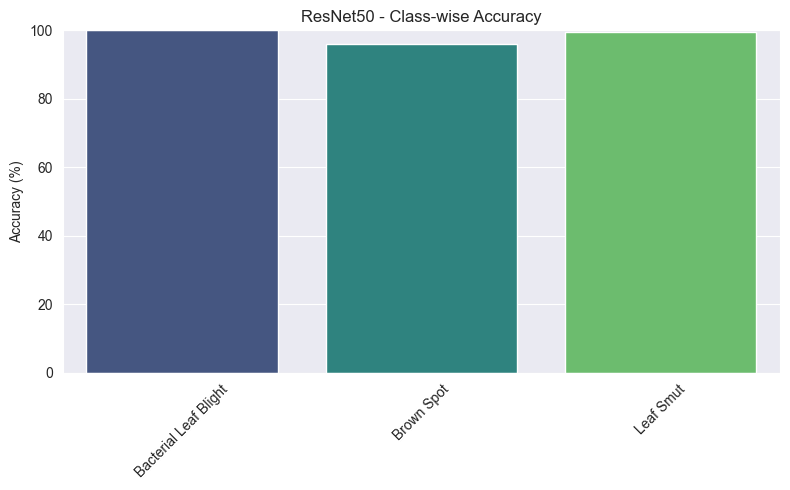

Class-wise Accuracy:

Bacterial Leaf Blight: 97.00%
Brown Spot: 57.50%
Leaf Smut: 81.00%


C:\Users\Kanyin AKinwande\AppData\Local\Temp\ipykernel_8632\2206870318.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=accuracies, palette="viridis")


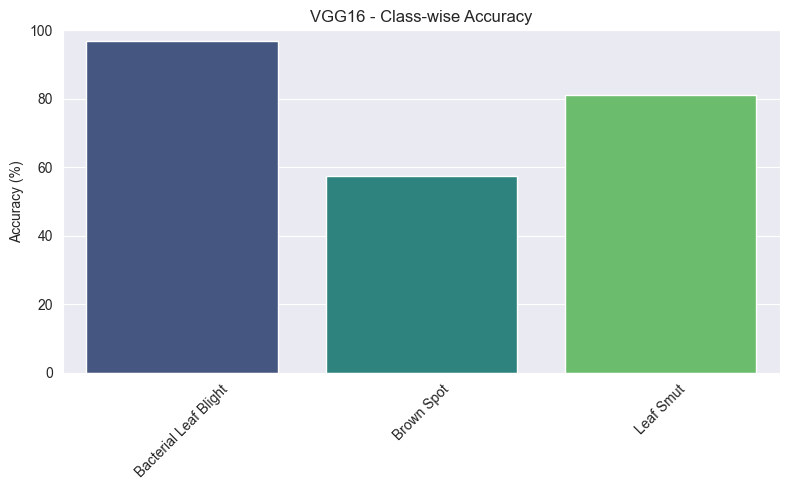

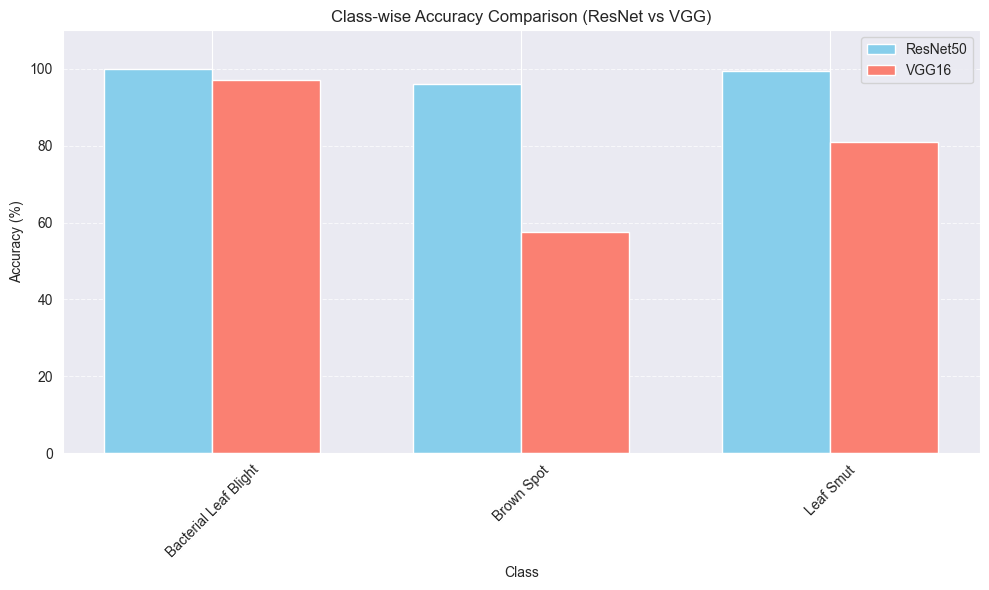

In [11]:
# class-wise performance

def class_wise_accuracy(y_true, y_pred, class_names):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Class-wise Accuracy:\n")
    for i, class_name in enumerate(class_names):
        class_indices = (y_true == i)
        correct_predictions = (y_pred[class_indices] == i).sum()
        total = class_indices.sum()
        accuracy = 100 * correct_predictions / total if total > 0 else 0.0
        print(f"{class_name}: {accuracy:.2f}%")

def plot_class_wise_accuracy(y_true, y_pred, class_names, model_name="Model"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracies = []
    for i in range(len(class_names)):
        class_indices = (y_true == i)
        correct = (y_pred[class_indices] == i).sum()
        total = class_indices.sum()
        accuracy = 100 * correct / total if total > 0 else 0.0
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=accuracies, palette="viridis")
    plt.ylim(0, 100)
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} - Class-wise Accuracy")
    plt.grid(True, axis="y")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# For ResNet
class_wise_accuracy(y_true_resnet, y_pred_resnet, class_names)
plot_class_wise_accuracy(y_true_resnet, y_pred_resnet, class_names, model_name="ResNet50")

# For VGG
class_wise_accuracy(y_true_vgg, y_pred_vgg, class_names)
plot_class_wise_accuracy(y_true_vgg, y_pred_vgg, class_names, model_name="VGG16")


# side by side accuracy
def plot_side_by_side_class_accuracy(y_true_resnet, y_pred_resnet, y_true_vgg, y_pred_vgg, class_names):
    y_true_resnet = np.array(y_true_resnet)
    y_pred_resnet = np.array(y_pred_resnet)
    y_true_vgg = np.array(y_true_vgg)
    y_pred_vgg = np.array(y_pred_vgg)

    resnet_acc = []
    vgg_acc = []

    for i in range(len(class_names)):
        # ResNet accuracy
        class_indices_r = (y_true_resnet == i)
        correct_r = (y_pred_resnet[class_indices_r] == i).sum()
        total_r = class_indices_r.sum()
        acc_r = 100 * correct_r / total_r if total_r > 0 else 0.0
        resnet_acc.append(acc_r)

        # VGG accuracy
        class_indices_v = (y_true_vgg == i)
        correct_v = (y_pred_vgg[class_indices_v] == i).sum()
        total_v = class_indices_v.sum()
        acc_v = 100 * correct_v / total_v if total_v > 0 else 0.0
        vgg_acc.append(acc_v)

    # Plotting
    x = np.arange(len(class_names))
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width / 2, resnet_acc, bar_width, label="ResNet50", color="skyblue")
    plt.bar(x + bar_width / 2, vgg_acc, bar_width, label="VGG16", color="salmon")

    plt.xlabel("Class")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-wise Accuracy Comparison (ResNet vs VGG)")
    plt.xticks(x, class_names, rotation=45)
    plt.ylim(0, 110)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_side_by_side_class_accuracy(
    y_true_resnet, y_pred_resnet,
    y_true_vgg, y_pred_vgg,
    class_names
)



### Print Model Summary

In [12]:


# Initialize models
#resnet = models.resnet50(pretrained=False)
#vgg = models.vgg16(pretrained=False)

# Print model summary for ResNet
print("ResNet50 Summary:")
summary(resnet, (3, 224, 224))  # (3, 224, 224) for RGB images (channels, height, width)

# Print model summary for VGG16
print("\nVGG16 Summary:")
summary(vgg, (3, 224, 224))


ResNet50 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14 

### Save and Load the Models

In [13]:
# Save Models
torch.save(resnet.state_dict(), "resnet50_rice.pth")
torch.save(vgg.state_dict(), "vgg16_rice.pth")

# Load Models
resnet.load_state_dict(torch.load("resnet50_rice.pth"))
vgg.load_state_dict(torch.load("vgg16_rice.pth"))


<All keys matched successfully>